In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(df.isna().sum().sum())

0


In [4]:
fraud_rate = df["Class"].mean()
print("Fraud rate:", fraud_rate)
print("Total fraud cases:", df["Class"].sum())
print(df["Class"].value_counts())

Fraud rate: 0.001727485630620034
Total fraud cases: 492
Class
0    284315
1       492
Name: count, dtype: int64


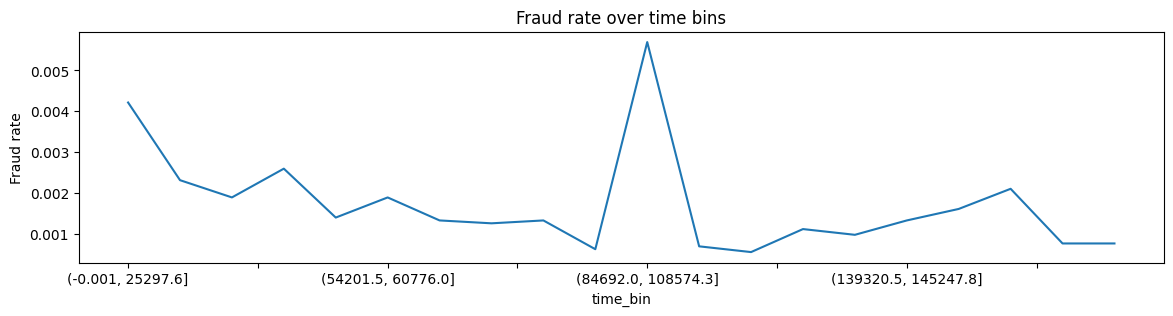

In [5]:
df = df.sort_values("Time")

# Переведём секунды в часы
df["Hour"] = df["Time"] / 3600

df["time_bin"] = pd.qcut(df["Time"], q=20)

fraud_by_time = df.groupby("time_bin")["Class"].mean()

plt.figure(figsize=(14, 3))
fraud_by_time.plot()
plt.title("Fraud rate over time bins")
# plt.xticks(rotation=45)
plt.ylabel("Fraud rate")
plt.show()

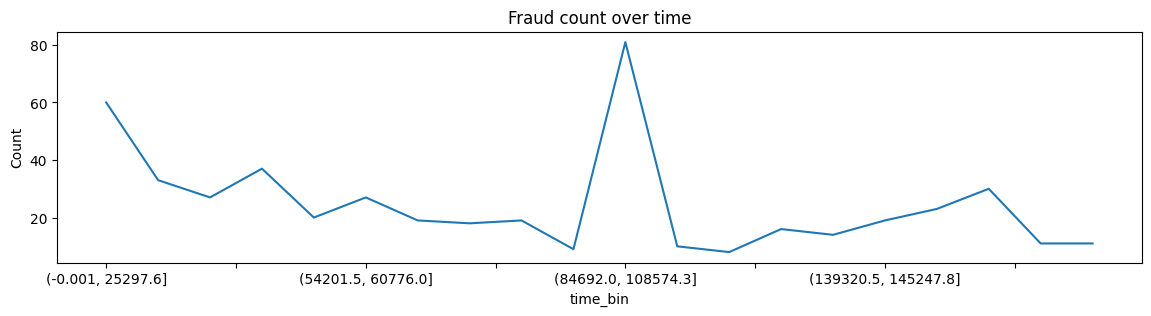

In [6]:
fraud_count = df.groupby("time_bin")["Class"].sum()

plt.figure(figsize=(14, 3))
fraud_count.plot()
plt.title("Fraud count over time")
plt.ylabel("Count")
plt.show()

In [7]:
df = df.sort_values("Time").reset_index(drop=True)
split_point = int(len(df) * 0.8)

train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]
print("Train fraud:", train_df["Class"].sum())
print("Test fraud:", test_df["Class"].sum())

Train fraud: 417
Test fraud: 75


In [8]:
print(train_df["Class"].mean())
print(test_df["Class"].mean())



0.001830191577607584
0.001316667251852112


In [9]:
print('Распределение Amount на трейне')
print(train_df["Amount"].describe())
print('Распределение Amount на тесте')
print(test_df["Amount"].describe())

Распределение Amount на трейне
count    227845.000000
mean         90.824919
std         250.503771
min           0.000000
25%           6.000000
50%          23.400000
75%          79.990000
max       19656.530000
Name: Amount, dtype: float64
Распределение Amount на тесте
count    56962.000000
mean        78.448549
std        248.335145
min          0.000000
25%          4.490000
50%         18.000000
75%         64.797500
max      25691.160000
Name: Amount, dtype: float64


In [10]:
from catboost import CatBoostClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)

drop_cols = ["Class", "time_bin", "amount_bin", "Time", "Hour"]
X_train = train_df.drop(columns=drop_cols, errors="ignore")
y_train = train_df["Class"]

X_test = test_df.drop(columns=drop_cols, errors="ignore")
y_test = test_df["Class"]

In [11]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

class_weights = [1, neg / pos]
print("Class weights:", class_weights)

Class weights: [1, np.float64(545.3908872901678)]


In [12]:
model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train)

0:	total: 159ms	remaining: 1m 19s
100:	total: 2.42s	remaining: 9.57s
200:	total: 4.46s	remaining: 6.63s
300:	total: 6.94s	remaining: 4.59s
400:	total: 8.98s	remaining: 2.22s
499:	total: 11s	remaining: 0us


CatBoostClassifier(class_weights=[1, np.float64(545.3908872901678)], depth=6, eval_metric='AUC', iterations=500, learning_rate=0.05, loss_function='Logloss', random_seed=42, verbose=100)

In [13]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

y_proba = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("ROC-AUC:", roc)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.9769796262766538
PR-AUC: 0.7915574194413296


In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Найдём threshold для recall ~0.8
idx = (np.abs(recall - 0.8)).argmin()
print("Threshold for recall~0.8:", thresholds[idx])
print("Precision at this threshold:", precision[idx])

Threshold for recall~0.8: 0.06866894312372153
Precision at this threshold: 0.32432432432432434


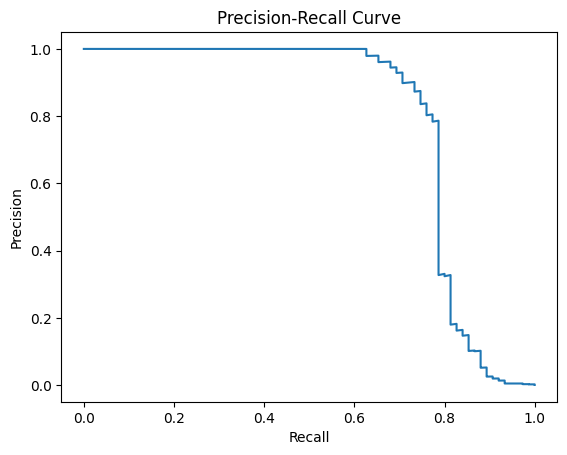

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix

def print_confusion(threshold):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nThreshold: {threshold}")
    print("Confusion matrix:")
    print(cm)
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")
    print(f"Recall: {tp / (tp + fn):.4f}")
    print(f"Precision: {tp / (tp + fp):.4f}")

# threshold 0.5
print_confusion(0.5)

# threshold для recall ~0.8
print_confusion(0.036069539416187464)


Threshold: 0.5
Confusion matrix:
[[56871    16]
 [   16    59]]
TP: 59, FP: 16, FN: 16, TN: 56871
Recall: 0.7867
Precision: 0.7867

Threshold: 0.036069539416187464
Confusion matrix:
[[56653   234]
 [   14    61]]
TP: 61, FP: 234, FN: 14, TN: 56653
Recall: 0.8133
Precision: 0.2068


In [17]:
split_p = int(len(X_train) * 0.8)

X_train_inner, y_train_inner = X_train.iloc[:split_p], y_train.iloc[:split_p]
X_Val_inner, y_Val_inner = X_train.iloc[split_p:], y_train.iloc[split_p:]

print(X_train_inner.shape)
print(X_Val_inner.shape)

(182276, 29)
(45569, 29)


In [18]:
from catboost import CatBoostClassifier

neg = (y_train_inner == 0).sum()
pos = (y_train_inner == 1).sum()

class_weights = [1, neg / pos]

model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    random_seed=42,
    verbose=0
)

model.fit(X_train_inner, y_train_inner)

CatBoostClassifier(class_weights=[1, np.float64(498.386301369863)], depth=6, eval_metric='AUC', iterations=500, learning_rate=0.05, loss_function='Logloss', random_seed=42, verbose=0)

In [19]:
y_val_proba = model.predict_proba(X_Val_inner)[:, 1]

In [20]:
C_fp = 5 

thresholds = np.linspace(0.0, 1.0, 500)

best_threshold = None
best_loss = float("inf")

for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)
    
    fp = ((y_pred == 1) & (y_Val_inner == 0)).sum()
    fn_mask = (y_pred == 0) & (y_Val_inner == 1)
    
    fn_amount = X_Val_inner.loc[fn_mask, "Amount"].sum()
    
    total_loss = fn_amount + C_fp * fp
    
    if total_loss < best_loss:
        best_loss = total_loss
        best_threshold = t

print("Best threshold:", best_threshold)
print("Validation expected loss:", best_loss)

Best threshold: 0.052104208416833664
Validation expected loss: 2103.56


In [21]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

class_weights = [1, neg / pos]

final_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    random_seed=42,
    verbose=0
)

final_model.fit(X_train, y_train)

CatBoostClassifier(class_weights=[1, np.float64(545.3908872901678)], depth=6, eval_metric='AUC', iterations=500, learning_rate=0.05, loss_function='Logloss', random_seed=42, verbose=0)

In [22]:
X_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='str')

In [23]:
y_test_proba = final_model.predict_proba(X_test)[:, 1]

y_test_pred = (y_test_proba >= best_threshold).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
print(cm)

[[56729   158]
 [   14    61]]


In [24]:
fp = ((y_test_pred == 1) & (y_test == 0)).sum()
fn_mask = (y_test_pred == 0) & (y_test == 1)

fn_amount = test_df.loc[fn_mask, "Amount"].sum()

test_loss = fn_amount + C_fp * fp

print("Test expected loss:", test_loss)

Test expected loss: 2553.49


In [25]:
THRESHOLD = best_threshold

In [27]:
y_proba = final_model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("ROC-AUC:", roc)
print("PR-AUC:", pr_auc)

ROC-AUC: 0.9769796262766538
PR-AUC: 0.7915574194413296


In [26]:
final_model.save_model("model/catboost_model.cbm")